In [ ]:
# 이전 몇일동안의 주식 data를 모두 종합해 다음 날의 종가가 얼마인지 추론하는 network를 만들어보자.
# 지금부터 우리가 만들 network는 아주 간단한 것으로 절대 주가를 정확하게 예측할 수 없다.
# 이건 예측을 하는 것이 아니라 RNN을 이용해 추세를 그려보는 것이다.

In [ ]:
# 절대 주가를 정확하게 예측하는 것이 아니다. 그저 단순히 RNN을 어떻게 구현하는지 알아보는 것이다.
# RNN으로 sequence data를 어떻게 추론하는지 그 방법을 익혀보자.

- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
- 검색 후 Historical Data 선택
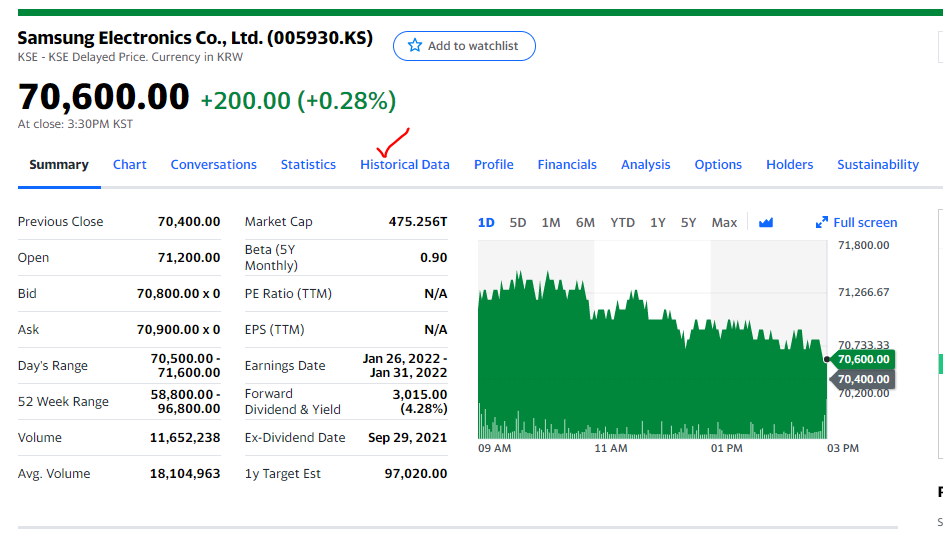

- 기간 선택 후 Apply -> Download 클릭
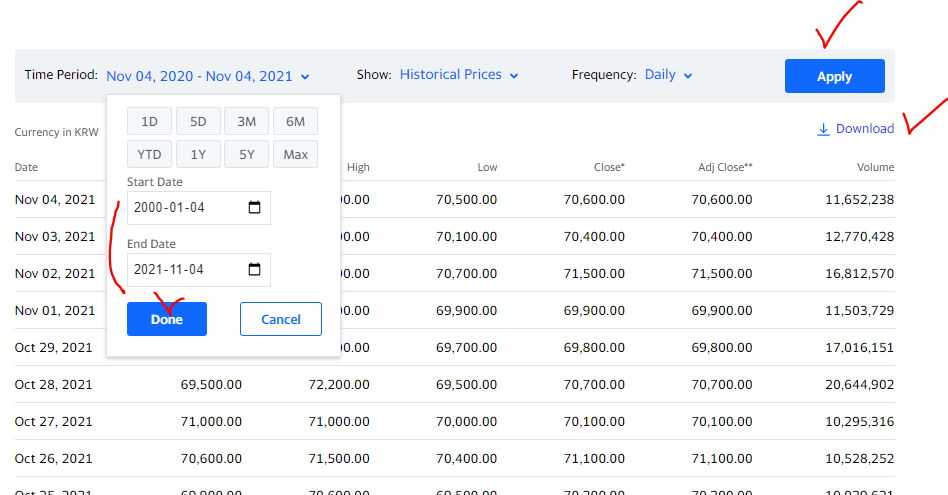

In [ ]:
# 2000-01-04부터 2023-03-03까지의 삼성 전자 주가 data를 csv 파일로 다운받았다.
# 2000-01-04부터 이걸 보고있는 현재 날짜까지의 삼성전자 주가 data를 다운받길 바란다.
# 그리고 다음 주식 장 개장일의 삼성전자 주가를 예측해보는 것이다.
# column name: 날짜 시가 최고가 최저가 종가 조정종가 거래량

##### 필요한 것 import

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data 관련
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# network 관련
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##### Data Loading 및 확인

In [2]:
df = pd.read_csv('data/samsung_stock_price.csv')
df.shape

(5814, 7)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000,6110,5660,6110,4563.383301,74195000
1,2000-01-05,5800,6060,5520,5580,4167.541992,74680000
2,2000-01-06,5750,5780,5580,5620,4197.417480,54390000
3,2000-01-07,5560,5670,5360,5540,4137.668457,40305000
4,2000-01-10,5600,5770,5580,5770,4309.447266,46880000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5814 entries, 0 to 5813
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5814 non-null   object 
 1   Open       5814 non-null   int64  
 2   High       5814 non-null   int64  
 3   Low        5814 non-null   int64  
 4   Close      5814 non-null   int64  
 5   Adj Close  5814 non-null   float64
 6   Volume     5814 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 318.1+ KB


In [ ]:
# NaN은 없는 것으로 확인된다.

##### 전처리
- date column을 index로 설정한다.
- 결측치 제거
- Adj Close 컬럼 제거
- MinMaxScaling

In [6]:
# data column을 index로 변환
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000,6110,5660,6110,4563.383301,74195000
2000-01-05,5800,6060,5520,5580,4167.541992,74680000
2000-01-06,5750,5780,5580,5620,4197.417480,54390000
2000-01-07,5560,5670,5360,5540,4137.668457,40305000
2000-01-10,5600,5770,5580,5770,4309.447266,46880000


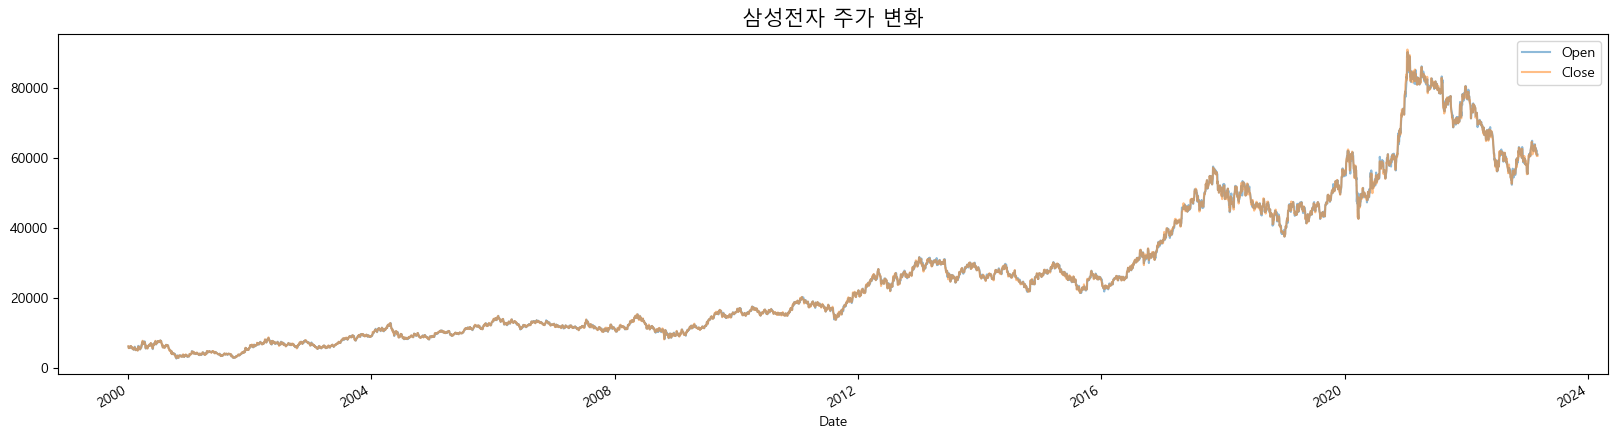

In [10]:
df[['Open', 'Close']].plot(figsize = (20, 5), alpha = 0.5)
plt.title('삼성전자 주가 변화', fontsize = 15)
plt.show()

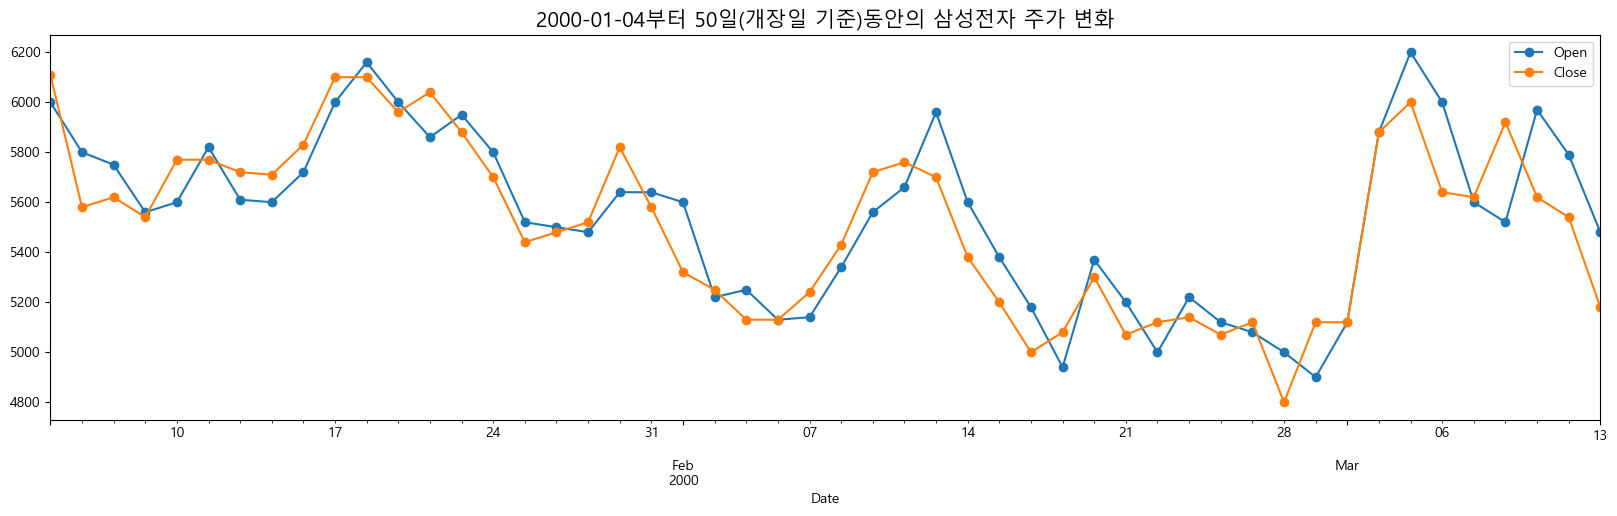

In [15]:
df[['Open', 'Close']].iloc[:50].plot(figsize = (20, 5), marker = 'o')
plt.title('2000-01-04부터 50일(개장일 기준)동안의 삼성전자 주가 변화', fontsize = 15)
plt.show()

In [17]:
# Adj Close column 제거
df.drop(columns = ['Adj Close'], inplace = True)

In [18]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,6000,6110,5660,6110,74195000
2000-01-05,5800,6060,5520,5580,74680000
2000-01-06,5750,5780,5580,5620,54390000
2000-01-07,5560,5670,5360,5540,40305000
2000-01-10,5600,5770,5580,5770,46880000


### X, y 분리

- X는 전체 값이고, y는 close이다.
- 우리가 지금 할려는 것은 이전 몇일동안의 data를 모두 종합해 다음 날의 종가가 얼마인지 추론하는 것이다.
- 그래서 X에는 모든 값을 넣고 y에는 close만 추출해 넣는다.

In [20]:
df_y = df['Close'].to_frame()
df_X = df

### Scaling - MinMaxScaler
- Scaler를 X, y 용 따로 만든다.
    - y를 inverse 하기 위해

In [41]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(df_X)
y = y_scaler.fit_transform(df_y)

In [42]:
X.shape, y.shape

((5814, 5), (5814, 1))

In [43]:
print(X.min(), X.max())
print(y.min(), y.max())

0.0 1.0
0.0 1.0


##  날짜 종가 예측
- X: 50일치 주가(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식가격을 할습하여 51일째 주가를 예측한다.
    - 한 개의 X data가 50일치 주가가 된다.
<br>

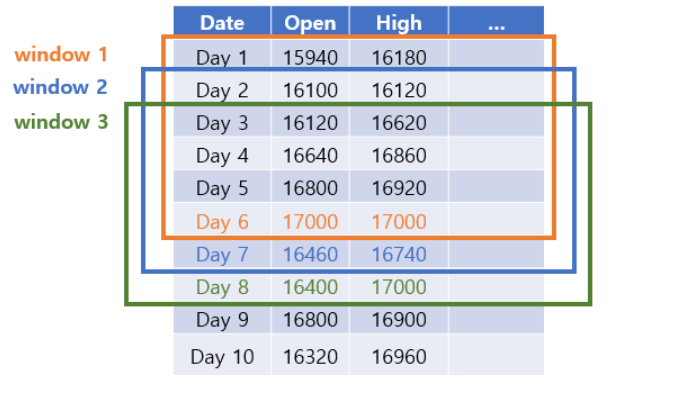
<center>[연속된 날짜가 5인 경우]</center>

X, y를 만든다.
각 index에 window size의 데이터셋이 들어가도록 한다.

##### input sequence dataset 만들기

In [ ]:
# fon in 문을 돌릴 때 마지막에 window_size + 1 개가 남을 때까지 반복한다.

In [55]:
# 최근 50일치를 하나의 sequence로 묶어 사용한다.
window_size = 50

# input data들을 저장할 list를 만든다.
data_X = []

# output data들을 저장할 list를 만든다.
data_y = []

for i in range(0, y.size - window_size):
    _X = X[i : i+window_size]
    _y = y[i+window_size]
    data_X.append(_X)
    data_y.append(_y)

In [56]:
np.shape(data_X)

(5764, 50, 5)

In [57]:
np.shape(data_y)

(5764, 1)

In [ ]:
# 지금까지 한 과정이 우리가 원하는 형태의 data set으로 바꾼 것이다.

## Train, Test 분리
- Train : 8, Test: 2의 비율로 나눈다.

In [ ]:
# train_test_split을 하게되면 random하게 순서가 뒤바뀐다.
# 그래서 sequence data로 만든 후 split해야 한다. 즉 50일씩 묶은 후에는 random하게 섞여도 무관한 것이다.
# 각각의 data 안의 날짜는 순서대로 그 모양이 유지되기 때문이다.
# 그래서 처음에 data를 받아온 후에 split을 하면 날짜 순서가 뒤바껴 순서가 중요한 RNN에 무의미한 data가 되므로 주의한다.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

In [59]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [61]:
X_train.shape, X_val.shape, X_test.shape

((3688, 50, 5), (923, 50, 5), (1153, 50, 5))

##### 하이퍼파라미터 정의

In [60]:
LEARNING_RATE = 0.001
N_EPOCH = 100
N_BATCH = 1000

##### Dataset 생성 

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder = True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

## Model 생성

- LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력을 할 수 있다. 
    - return_sequences=True: 시퀀스마다 결과를 출력. False(기본값): 전체 Sequence를 처리하고 결과를 하나만 출력
- many to many 문제를 풀거나 LSTM 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 옵션을 사용. 
- Fully Connected Layer(Dense)와 연결된 경우 return_sequence=False로 해서 하나만 전달.
- 아래 그림에서 왼쪽은 return_sequences=False일 때, 오른쪽은 return_sequence=True일 때의 형상.

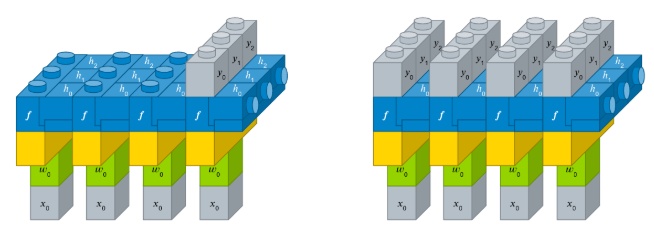

<center>[출처: https://tykimos.github.io/2017/04/09/RNN_Getting_Started]</center>

In [ ]:
# return_sequences에 대해서
    # True 혹은 False만 줄 수 있다.
    # 위 그림에서 오른쪽이 False 왼쪽이 True이다.
    # False면 마지막 한 번만 처리 결과가 나오는 것이고 True면 처리할 때마다 출력 결과가 나온다.
    # sequence to vector면 False로 하고 sequence to sequence면 True로 하면 된다.
    # 그래서 여기서는 False로 했다.

##### 모델 생성, 컴파일

In [86]:
def get_model(lr = 0.01):
    # Network 생성
    model = keras.Sequential()
    
    # Network 정의  
    # Input Layer
    model.add(layers.InputLayer(input_shape = (window_size, 5)))
    
    # feature extractor
    model.add(layers.LSTM(units = 32, return_sequences = False, activation = 'tanh'))
    # estimator
    model.add(layers.Dense(units = 32, activation = 'relu'))
    
    # Output Layer
    model.add(layers.Dense(units = 1))
    
    
    # Network Compile
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss = 'mse')
    
    return model

In [87]:
model = get_model(LEARNING_RATE)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4864      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


##### 모델 학습, 평가

In [88]:
hist = model.fit(train_dataset, epochs = N_EPOCH, validation_data = val_dataset)

Epoch 1/100
3/3 [==============================] - 3s 370ms/step - loss: 0.0830 - val_loss: 0.0554
Epoch 2/100
3/3 [==============================] - 0s 109ms/step - loss: 0.0511 - val_loss: 0.0311
Epoch 3/100
3/3 [==============================] - 0s 131ms/step - loss: 0.0266 - val_loss: 0.0138
Epoch 4/100
3/3 [==============================] - 0s 101ms/step - loss: 0.0106 - val_loss: 0.0036
Epoch 5/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/100
3/3 [==============================] - 0s 137ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 7/100
3/3 [==============================] - 0s 162ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 0s 139ms/step - loss: 0.0028 - val_loss: 9.9256e-04
Epoch 9/100
3/3 [==============================] - 0s 123ms/step - loss: 7.0826e-04 - val_loss: 6.8065e-04
Epoch 10/100
3/3 [==============================] - 0s 116ms/step - loss: 0.0010 - val_loss: 0.00

Epoch 78/100
3/3 [==============================] - 0s 159ms/step - loss: 1.1517e-04 - val_loss: 1.1925e-04
Epoch 79/100
3/3 [==============================] - 0s 144ms/step - loss: 1.2032e-04 - val_loss: 1.1875e-04
Epoch 80/100
3/3 [==============================] - 0s 111ms/step - loss: 1.1604e-04 - val_loss: 1.1816e-04
Epoch 81/100
3/3 [==============================] - 0s 98ms/step - loss: 1.2257e-04 - val_loss: 1.1741e-04
Epoch 82/100
3/3 [==============================] - 0s 89ms/step - loss: 1.1790e-04 - val_loss: 1.1829e-04
Epoch 83/100
3/3 [==============================] - 0s 106ms/step - loss: 1.1421e-04 - val_loss: 1.1647e-04
Epoch 84/100
3/3 [==============================] - 0s 96ms/step - loss: 1.1998e-04 - val_loss: 1.1611e-04
Epoch 85/100
3/3 [==============================] - 0s 122ms/step - loss: 1.1939e-04 - val_loss: 1.1666e-04
Epoch 86/100
3/3 [==============================] - 0s 109ms/step - loss: 1.2137e-04 - val_loss: 1.1530e-04
Epoch 87/100
3/3 [=============

##### 결과 시각화

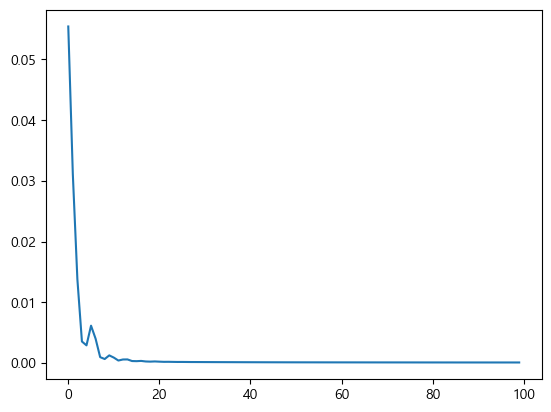

In [89]:
plt.plot(hist.epoch, hist.history['val_loss'])
plt.show()

##### 최종평가

In [90]:
model.evaluate(test_dataset)

2/2 [==============================] - 0s 13ms/step - loss: 1.1418e-04


0.00011417861969675869

##### 다음날 주가 예측
- 마지막 50일치로 다음 개장일 종가를 예측해 본다.

In [91]:
new_data = X[-50:][np.newaxis, ...]
new_data.shape

(1, 50, 5)

In [92]:
pred = model.predict(new_data)
pred

1/1 [==============================] - 0s 442ms/step


array([[0.6675062]], dtype=float32)

In [93]:
y_scaler.inverse_transform(pred)

array([[61650.773]], dtype=float32)